In [2]:
import numpy as np
import pandas as pd
import pgaccess as pg
import seaborn as sns
import matplotlib.pyplot as plt

My thought here is to check the average delay between pairs of airports. These dealys can probably be plotted on a heatmap

In [3]:
df = pg.execute_query('''
SELECT
    origin_airport_id,
    dest_airport_id,
    AVG(arr_delay) AS ave_delay
FROM flights
GROUP BY origin_airport_id, dest_airport_id
ORDER BY
    origin_airport_id ASC,
    dest_airport_id ASC
''')
df

,origin_airport_id,dest_airport_id,ave_delay
0,10135,10397,3.956590
1,10135,10693,19.985075
2,10135,11057,1.558610
3,10135,11433,10.452493
4,10135,11697,55.304000
...,...,...,...
6988,16133,14761,9.000000
6989,16218,11298,5.667692
6990,16218,14107,-1.391216
6991,16869,11292,41.122951


In [35]:
# Remove null values, there seem to be about 60 nulls
df = df.dropna()

In [36]:
# Bring the airport ids into column and row indexes
# Origin airport on the left, destination on the top
indexed = df.pivot(index='origin_airport_id', columns='dest_airport_id')
indexed

ave_delay                                                  \
dest_airport_id       10135 10136 10140 10141 10146 10154 10155 10157 10158   
origin_airport_id                                                             
10135                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10136                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10140                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10141                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10146                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
15991                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16101                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16133                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16218                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16869                   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                         ...                                                  \
dest_airport_id   10165  ... 15607 15624 15841 15897 15919 15991 16101 16133   
origin_airport_id        ...                                                   
10135               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10136               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10140               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10141               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
10146               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                 ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
15991               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16101               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16133               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16218               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16869               NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                               
dest_airport_id   16218 16869  
origin_airport_id              
10135               NaN   NaN  
10136               NaN   NaN  
10140               NaN   NaN  
10141               NaN   NaN  
10146               NaN   NaN  
...                 ...   ...  
15991               NaN   NaN  
16101               NaN   NaN  
16133               NaN   NaN  
16218               NaN   NaN  
16869               NaN   NaN  

[376 rows x 376 columns]

There are a lot of nulls there. That's not terribly surprising, as not every airport has a flight to every other airport. It could still be worth investigating the heatmap anyways

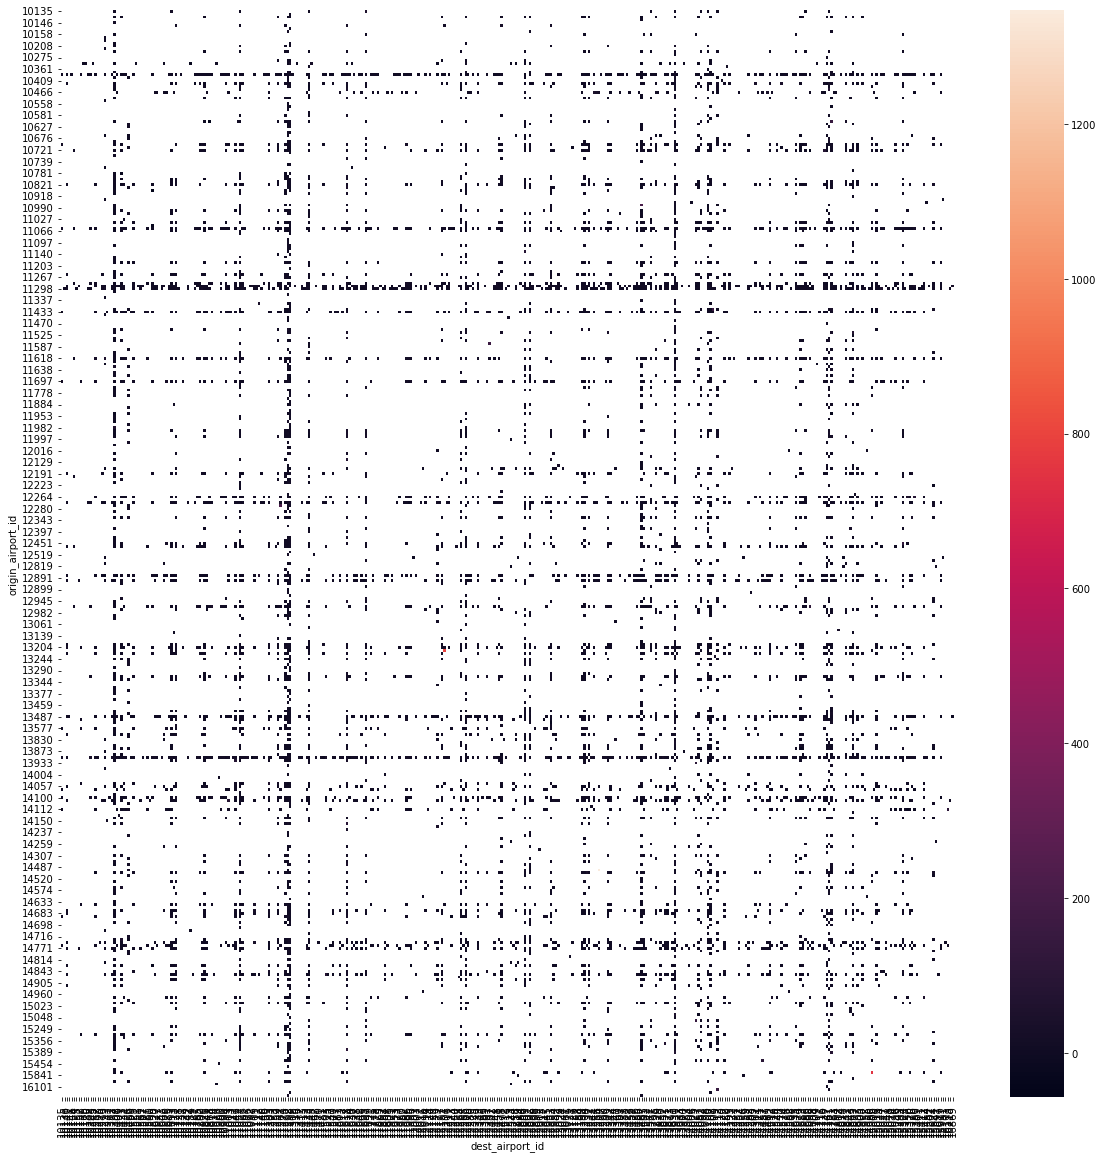

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    indexed,
    ax = ax,
    xticklabels = indexed.columns.get_level_values(1)
)
ax.set_xlabel('dest_airport_id')
plt.show()

This isn't very helpful in terms of actual delay values. Though it does really show how few connections there are between arbitrary airports. There are some airports that serve as main hubs, smaller airports only fly to those 'main hub' airports.  
There isn't much variation in values, but given the scale goes up to 1200 there must be at least one connection with that as its average.

Check the actual descriptive values

In [37]:
df['ave_delay'].describe()

count    6939.000000
mean        6.512126
std        23.544241
min       -56.571429
25%         0.776980
50%         4.789216
75%         9.609886
max      1347.000000
Name: ave_delay, dtype: float64

We can take out the outliers from here, then try the heatmap again.

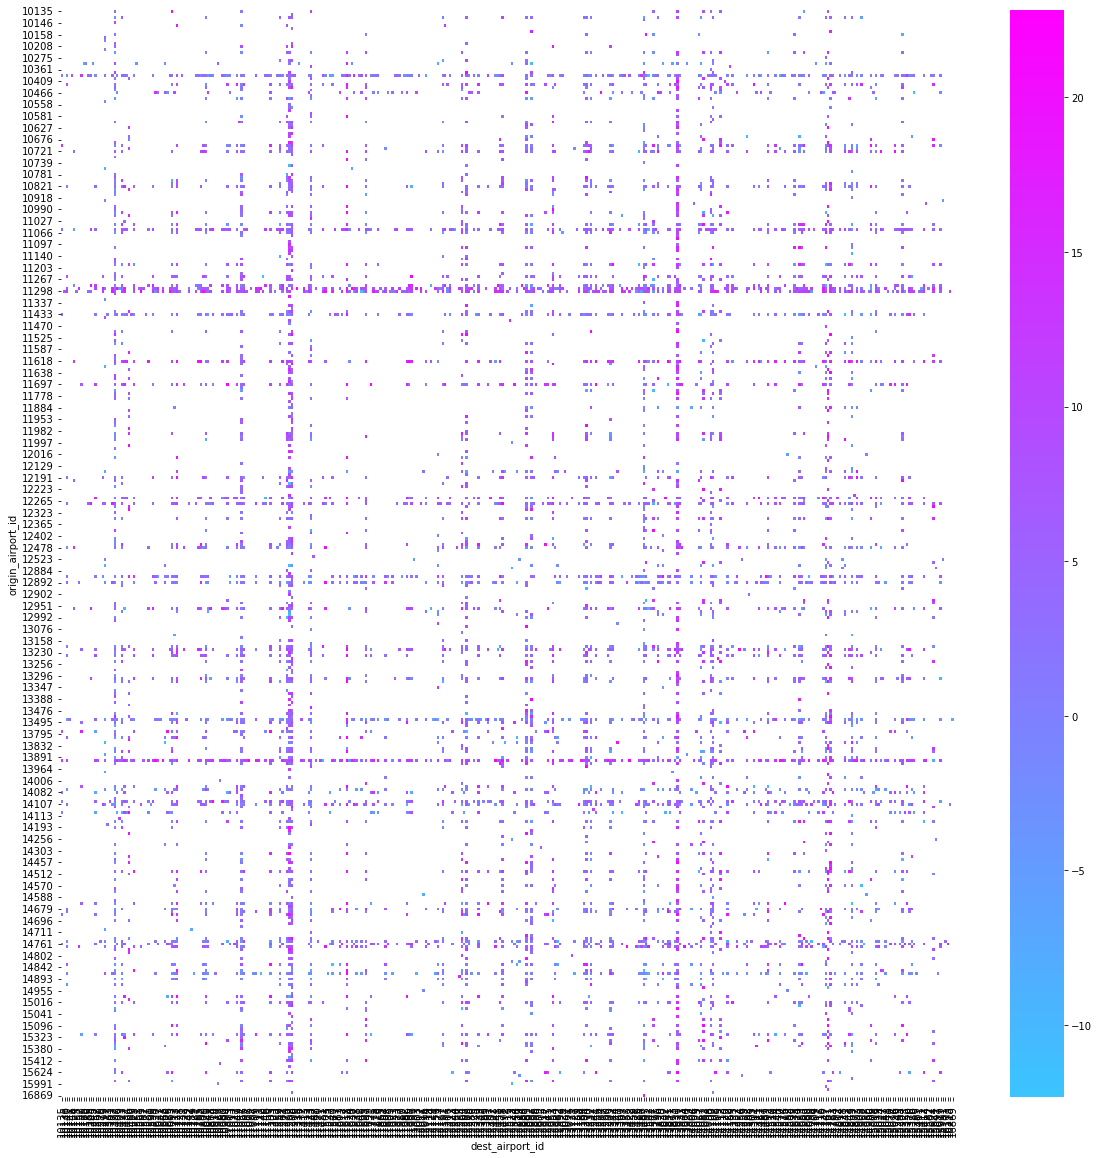

In [50]:
firstQ = np.quantile(df['ave_delay'], 0.25)
thirdQ = np.quantile(df['ave_delay'], 0.75)
iqr = thirdQ - firstQ
smallOutlier = firstQ - (iqr * 1.5)
bigOutlier = thirdQ + (iqr * 1.5)
remOutlier = df[
    (df['ave_delay'] > smallOutlier) & (df['ave_delay'] < bigOutlier)
].pivot(index='origin_airport_id', columns='dest_airport_id')

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    remOutlier,
    ax = ax,
    xticklabels = remOutlier.columns.get_level_values(1),
    cmap = 'cool',
    center = 0
)
ax.set_xlabel('dest_airport_id')
plt.show()

It is at this point I think it would be best to also get the count of flights, and remove routes where only a couple of flights are contributing to the average.

In [51]:
df = pg.execute_query('''
SELECT
    origin_airport_id,
    dest_airport_id,
    AVG(arr_delay) AS ave_delay,
    COUNT(*) AS flight_count
FROM flights
GROUP BY origin_airport_id, dest_airport_id
ORDER BY
    origin_airport_id ASC,
    dest_airport_id ASC
''')
df = df.dropna()
df

,origin_airport_id,dest_airport_id,ave_delay,flight_count
0,10135,10397,3.956590,1926
1,10135,10693,19.985075,67
2,10135,11057,1.558610,1994
3,10135,11433,10.452493,1927
4,10135,11697,55.304000,128
...,...,...,...,...
6988,16133,14761,9.000000,1
6989,16218,11298,5.667692,331
6990,16218,14107,-1.391216,2964
6991,16869,11292,41.122951,258


In [56]:
# Cut out rows with less than 5 flights
df = df[df['flight_count'] > 5]
df

,origin_airport_id,dest_airport_id,ave_delay,flight_count
0,10135,10397,3.956590,1926
1,10135,10693,19.985075,67
2,10135,11057,1.558610,1994
3,10135,11433,10.452493,1927
4,10135,11697,55.304000,128
...,...,...,...,...
6986,16101,14747,5.777371,2514
6989,16218,11298,5.667692,331
6990,16218,14107,-1.391216,2964
6991,16869,11292,41.122951,258


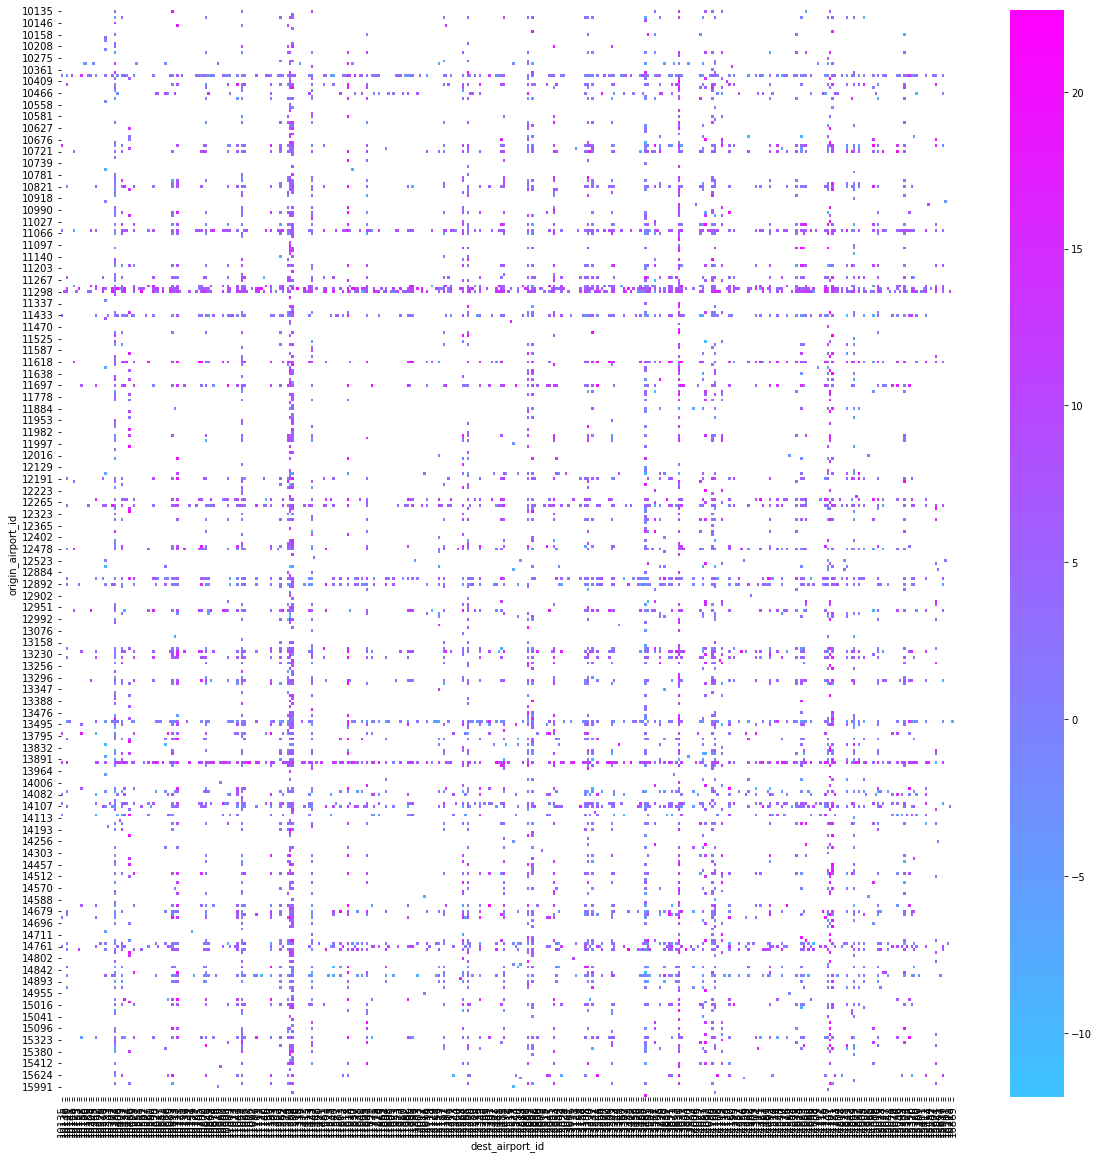

In [59]:
# Show heatmap
firstQ = np.quantile(df['ave_delay'], 0.25)
thirdQ = np.quantile(df['ave_delay'], 0.75)
iqr = thirdQ - firstQ
smallOutlier = firstQ - (iqr * 1.5)
bigOutlier = thirdQ + (iqr * 1.5)
remOutlier = df[
    (df['ave_delay'] > smallOutlier) & (df['ave_delay'] < bigOutlier)
].pivot(index='origin_airport_id', columns='dest_airport_id', values='ave_delay')

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    remOutlier,
    ax = ax,
    xticklabels = remOutlier.columns,#.get_level_values(1),
    cmap = 'cool',
    center = 0
)
ax.set_xlabel('dest_airport_id')
plt.show()

I'm not sure if there's anything more I can infer from looking at this. But the numbers themselves will probably be useful as a component of prediction. The values can be saved to a file

In [60]:
remOutlier.to_csv('../data/delays_per_airport_pair.csv')